In [1]:
#Import Libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from plotnine import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from math import *
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

weed = pd.read_csv("C:/Users/ryanc/Desktop/GSB_544/Data/cannabis_full.csv")
weed = weed.dropna()

twotypes = weed

## Part One: Binary Classification

Create a dataset that is limited only to the Sativa and Indica type cannabis strains.

This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.

For each, you should:

- Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)

- Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

- Report the (cross-validated!) metric.

- Fit the final model.

- Output a confusion matrix.

In [2]:
# Cleaning

twotypes = twotypes.drop(['Flavor', 'Effects', 'Strain'], axis=1)
twotypes = twotypes[(weed['Type'] == 'sativa') | (weed['Type'] == 'indica')]


X = twotypes.drop(['Type'], axis = 1)
y = twotypes['Type']

### Q1: LDA

In [3]:
LDA = Pipeline(
  [
  ("lda", LinearDiscriminantAnalysis())]
)

lda_rocauc = cross_val_score(LDA, X, y, cv=5, scoring='roc_auc').mean()

LDAfit = LDA.fit(X,y)
y_preds = LDAfit.predict(X)
lda_matrix = confusion_matrix(y, y_preds)

print(f"LDA ROC AUC: {lda_rocauc}")
print(f"Confusion Matrix")
print(lda_matrix)

LDA ROC AUC: 0.9260402178812139
Confusion Matrix
[[627  60]
 [ 86 345]]


ROC-AUC seems to be an appropriate measure for a binary classifier, and we are only working with two strains, so it is also binary.

### Q2: QDA

In [4]:
QDA = Pipeline(
  [
  ("QDA", QuadraticDiscriminantAnalysis())]
)

qda_score = cross_val_score(QDA, X, y, cv=5, scoring='roc_auc').mean()

QDAfit = QDA.fit(X,y)
y_preds_qda = QDAfit.predict(X)
qda_matrix = confusion_matrix(y, y_preds_qda)

print(f"QDA ROC AUC: {qda_score}")
print(f"Confusion Matrix")
print(qda_matrix)

QDA ROC AUC: 0.7639214173256268
Confusion Matrix
[[ 25 662]
 [  0 431]]


C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear


Same as before, QDA can also be measured through ROC AUC due to the binary setting between indica and sativa.

### Q3: SVC

In [5]:
pipeline_svc = Pipeline([('classifier', SVC(kernel = 'linear'))])

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto']
}

grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=5, scoring='f1_macro')
fitted_pipeline_svc = grid_search_svc.fit(X, y)

#get best estimator and params
best_svc = fitted_pipeline_svc.best_estimator_.named_steps['classifier']
best_params_svc = fitted_pipeline_svc.best_params_
best_score_svc = fitted_pipeline_svc.best_score_

#make predictions for confusion matrix
y_preds_svc = cross_val_predict(best_svc, X, y, cv=5)

conf_matrix_svc = confusion_matrix(y, y_preds_svc)

best_params_svc, best_score_svc, conf_matrix_svc

({'classifier__C': 0.1, 'classifier__gamma': 'scale'},
 0.8400849513852038,
 array([[630,  57],
        [108, 323]], dtype=int64))

### Q4: SVM

In [6]:
pipeline_svm = Pipeline([('SVM', SVC(kernel = 'poly'))])

param_svm = {
    'SVM__C': [0.1, 1, 10],
    'SVM__degree': [2, 3, 4, 5],
    'SVM__gamma': ['scale', 'auto']
}

gscv_svm = GridSearchCV(pipeline_svm, param_svm, cv=5, scoring='f1_macro')
gscv_svm_fitted = gscv_svm.fit(X,y)

#Bestimators and parameters
best_svm = gscv_svm_fitted.best_estimator_.named_steps['SVM']
best_params_svm = gscv_svm_fitted.best_params_
best_score_svm = gscv_svm_fitted.best_score_

#make predictions for confusion matrix
y_preds_svm = cross_val_predict(best_svm, X, y, cv=5)

conf_matrix_svm = confusion_matrix(y, y_preds_svm)

best_params_svm, best_score_svm, conf_matrix_svm

({'SVM__C': 1, 'SVM__degree': 5, 'SVM__gamma': 'scale'},
 0.8439851316459845,
 array([[626,  61],
        [101, 330]], dtype=int64))

## Part Two: Natural Multiclass

Now use the full dataset, including the Hybrid strains.

In [7]:
weed = weed.dropna()
weed = weed.drop(['Flavor', 'Effects', 'Strain'], axis=1)

weed['Type'] = weed['Type'].astype('category')
weed_mapping = {'sativa': 0, 'indica': 1, 'hybrid': 2}
weed['Type_new'] = weed['Type'].map(weed_mapping)

X = weed.drop(['Type', 'Type_new'], axis=1)
y= weed['Type_new']

### Q1
Fit a decision tree, plot the final fit, and interpret the results.

In [8]:
pipeline_d_tree = Pipeline([
    ('classifier', DecisionTreeClassifier(random_state=0))
])

param_grid_d_tree = {
    'classifier__min_impurity_decrease' : [.001, .05, .1, .25, .5, .75, 1]
}

grid_search_d_tree = GridSearchCV(pipeline_d_tree, param_grid_d_tree, cv=5, scoring='f1_macro')
fitted_pipeline_d_tree = grid_search_d_tree.fit(X, y)

#get best estimator and its parameters
best_d_tree = fitted_pipeline_d_tree.best_estimator_.named_steps['classifier']
best_params_decision_tree = grid_search_d_tree.best_params_
best_score_decision_tree = grid_search_d_tree.best_score_

best_params_decision_tree, best_score_decision_tree

({'classifier__min_impurity_decrease': 0.001}, 0.5628257054798403)

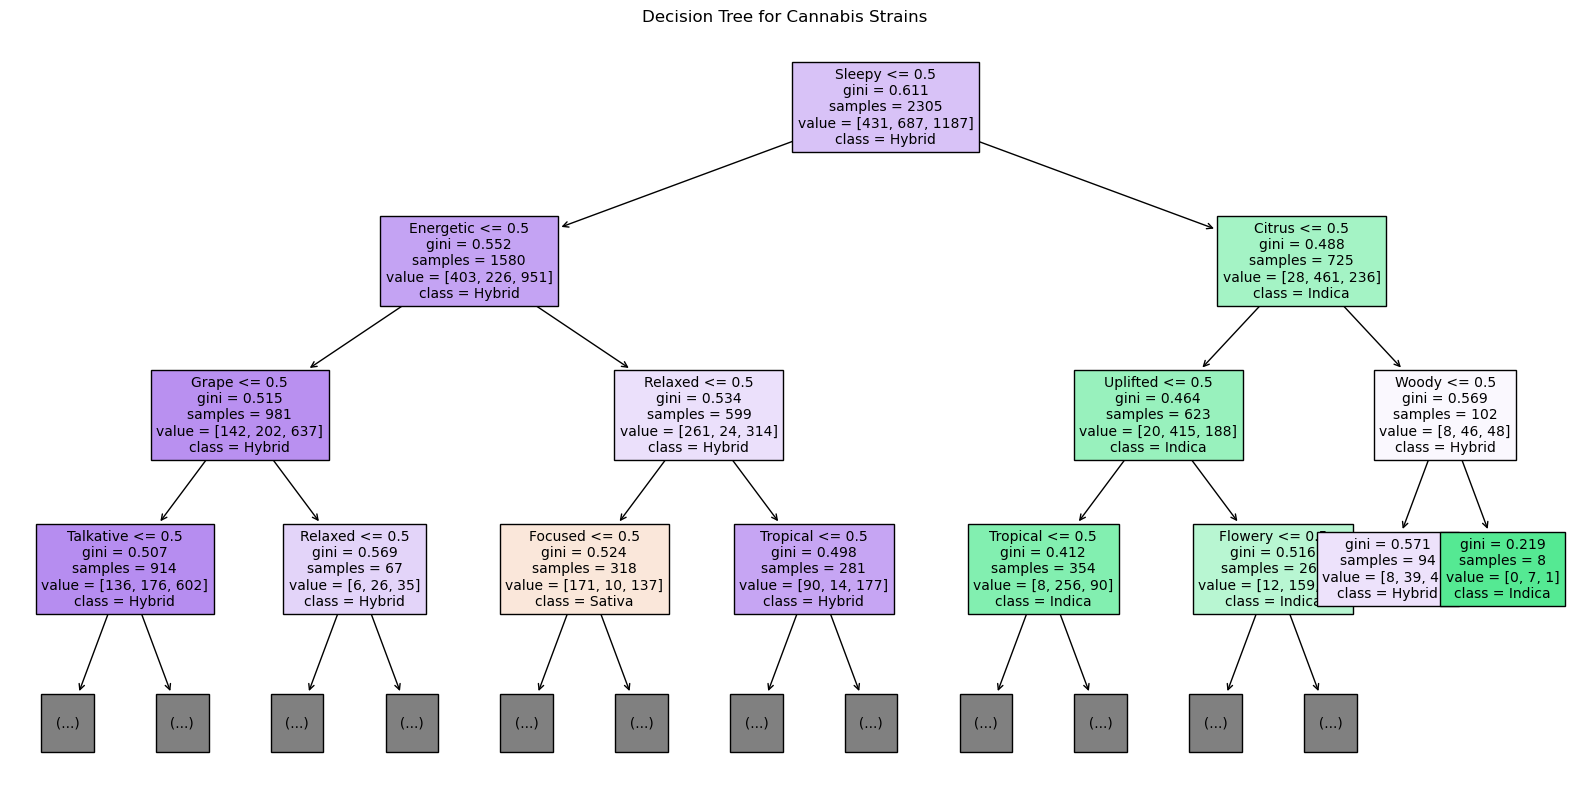

In [9]:
#plot best decision tree
plt.figure(figsize=(20,10))
plot_tree(best_d_tree,
          filled=True,
          feature_names=X.columns.tolist(),
          class_names=['Sativa', 'Indica', 'Hybrid'],
          max_depth=3,
          fontsize=10)
plt.title("Decision Tree for Cannabis Strains")
plt.show()

According to the decision tree, 'sleepy' is the best predictor of weed type. When smokers report being sleepy, it indicates they are smoking either indica or a hybrid. To determine if it is indica, we identify the instances where someone is energetic or not relaxed. Predictors like Citrus and Woody will also help determine whether a sleepy person is smoking an indica or a hybrid.

### Q2
Repeat the analyses from Part One for LDA, QDA, and KNN.

In [10]:
pipeline_lda_full = Pipeline([
    ('classifier', LinearDiscriminantAnalysis())
])
param_grid_lda_full = {'classifier__solver': ['svd', 'lsqr']}
grid_search_lda_full = GridSearchCV(pipeline_lda_full, param_grid_lda_full, cv=5, scoring='f1_macro')

fitted_pipeline_lda_full = grid_search_lda_full.fit(X, y)

#extracting best parameters, score, and confusion matrix for LDA
best_lda_full = fitted_pipeline_lda_full.best_estimator_.named_steps['classifier']
best_params_lda_full = fitted_pipeline_lda_full.best_params_
best_score_lda_full = fitted_pipeline_lda_full.best_score_
y_preds_lda_full = cross_val_predict(best_lda_full, X, y, cv=5)
conf_matrix_lda_full = confusion_matrix(y, y_preds_lda_full)

best_params_lda_full, best_score_lda_full, conf_matrix_lda_full

({'classifier__solver': 'svd'},
 0.5939249916749908,
 array([[178,  23, 230],
        [ 12, 455, 220],
        [146, 224, 817]], dtype=int64))

In [11]:
pipeline_qda_full = Pipeline([
    ('classifier', QuadraticDiscriminantAnalysis())
])
param_grid_qda_full = {'classifier__reg_param': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}
grid_search_qda_full = GridSearchCV(pipeline_qda_full, param_grid_qda_full, cv=5, scoring='f1_macro')

fitted_pipeline_qda_full = grid_search_qda_full.fit(X, y)

#extracting best parameters, score, and confusion matrix for QDA
best_qda_full = fitted_pipeline_qda_full.best_estimator_.named_steps['classifier']
best_params_qda_full = fitted_pipeline_qda_full.best_params_
best_score_qda_full = fitted_pipeline_qda_full.best_score_
y_preds_qda_full = cross_val_predict(best_qda_full, X, y, cv=5)
conf_matrix_qda_full = confusion_matrix(y, y_preds_qda_full)

best_params_qda_full, best_score_qda_full, conf_matrix_qda_full

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\discr

({'classifier__reg_param': 0.2},
 0.5675978960574473,
 array([[139,  26, 266],
        [  5, 487, 195],
        [116, 283, 788]], dtype=int64))

In [12]:
pipeline_knn_full = Pipeline([
    ('classifier', KNeighborsClassifier())
])
param_grid_knn_full = {'classifier__n_neighbors': [5, 10, 15], 'classifier__weights': ['uniform', 'distance']}
grid_search_knn_full = GridSearchCV(pipeline_knn_full, param_grid_knn_full, cv=5, scoring='f1_macro')

fitted_pipeline_knn_full = grid_search_knn_full.fit(X, y)

#extracting best parameters, score, and confusion matrix for KNN
best_knn_full = fitted_pipeline_knn_full.best_estimator_.named_steps['classifier']
best_params_knn_full = fitted_pipeline_knn_full.best_params_
best_score_knn_full = fitted_pipeline_knn_full.best_score_
y_preds_knn_full = cross_val_predict(best_knn_full, X, y, cv=5)
conf_matrix_knn_full = confusion_matrix(y, y_preds_knn_full)

best_params_knn_full, best_score_knn_full, conf_matrix_knn_full

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.51644052        nan 0.52802501        nan 0.53137335]


({'classifier__n_neighbors': 15, 'classifier__weights': 'distance'},
 0.5313733524000763,
 array([[115,  24, 292],
        [  7, 390, 290],
        [102, 222, 863]], dtype=int64))

### Q3
Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

The scores from Binary Classification were significantly better than with the Natural Multiclass section. Considering the fact that binary classification only relies on two categories ("indica" vs "sativa"), it makes sense that it would get better results. 

When the new value of "hybrid" is added into the models, it becomes harder to distinguish from all the classifications, especially as the "hybrid" category has a combination of traits from the other two. More than anything, we can see that it is difficult to identify hybrid strains, as many of the other two strains get misclassified as hybrid.

## Part Three: Multiclass from Binary
Consider two models designed for binary classification: SVC and Logistic Regression.

### Q1
Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:

- Indica vs. Not Indica

- Sativa vs. Not Sativa

- Hybrid vs. Not Hybrid

In [15]:
#dummies = pd.get_dummies(weed['Type'], prefix = "Type_is")
#can = weed.join(dummies)
weed.head()

,Type,Rating,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,...,Butter,Pineapple,Tar,Rose,Plum,Pear,Type_new,Type_is_hybrid,Type_is_indica,Type_is_sativa
0,hybrid,4.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,0
1,hybrid,4.7,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,0
2,sativa,4.4,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
3,hybrid,4.2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,0
4,hybrid,4.6,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,0


### Indica vs Not Indica

In [18]:
X = weed.drop(['Type', 'Type_new', 'Type_is_hybrid', 'Type_is_indica', 'Type_is_sativa'], axis=1)
y = weed['Type_is_indica']

Log = Pipeline(
    [('Log', LogisticRegression())]
)

cross_val_score(Log, X,y, cv=5, scoring = "f1_macro").mean()

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.7464307015675271

In [20]:
svc = Pipeline([("svc", SVC())])
tune = {'svc__C': [.12,.1,.001,.2,.3,.4,5,.6,.7,.7,.8,.9,1,2,3,4,5,6,7,8,9,10]}

gscv1 = GridSearchCV(svc, tune, cv = 5, scoring='f1_macro')
gscv1fit = gscv1.fit(X,y)
svc = Pipeline([("svc", SVC(C=gscv1fit.best_params_.get('svc__C')))])
cross_val_score(svc, X, y, cv=5, scoring='f1_macro').mean()

0.7505703033017431

## Sativa vs Not Sativa

In [21]:
X = weed.drop(['Type', 'Type_new', 'Type_is_hybrid', 'Type_is_indica', 'Type_is_sativa'], axis=1)
y = weed['Type_is_sativa']

Log = Pipeline(
    [('Log', LogisticRegression())]
)

cross_val_score(Log, X,y, cv=5, scoring = "f1_macro").mean()

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.6458088347148756

In [22]:
svc = Pipeline([("svc", SVC())])
tune = {'svc__C': [.12,.1,.001,.2,.3,.4,5,.6,.7,.7,.8,.9,1,2,3,4,5,6,7,8,9,10]}

gscv1 = GridSearchCV(svc, tune, cv = 5, scoring='f1_macro')
gscv1fit = gscv1.fit(X,y)
svc = Pipeline([("svc", SVC(C=gscv1fit.best_params_.get('svc__C')))])
cross_val_score(svc, X, y, cv=5, scoring='f1_macro').mean()

0.6473181193705826

## Hybrid vs Not Hybrid

In [23]:
X = weed.drop(['Type', 'Type_new', 'Type_is_hybrid', 'Type_is_indica', 'Type_is_sativa'], axis=1)
y = weed['Type_is_hybrid']

Log = Pipeline(
    [('Log', LogisticRegression())]
)

cross_val_score(Log, X,y, cv=5, scoring = "f1_macro").mean()

0.6146536090721264

In [24]:
svc = Pipeline([("svc", SVC())])
tune = {'svc__C': [.12,.1,.001,.2,.3,.4,5,.6,.7,.7,.8,.9,1,2,3,4,5,6,7,8,9,10]}

gscv1 = GridSearchCV(svc, tune, cv = 5, scoring='f1_macro')
gscv1fit = gscv1.fit(X,y)
svc = Pipeline([("svc", SVC(C=gscv1fit.best_params_.get('svc__C')))])
cross_val_score(svc, X, y, cv=5, scoring='f1_macro').mean()

0.6320764171469142

### Q2
Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?

The BEST model of all of them was the SVC distinguishing Indica from Not Indica, which does make intuitive sense because it is a strain that makes people sleepy. It would be easier to tell if someone was sleepy vs not sleepy, as these are very different from one another.

The WORST model was the logistic regression of Hybrid vs Not Hybrid, which also makes intuitive sense. Main reason for this is that the hybrid usually has a blend of the other two types, therefore it would be more difficult to get a get accuracy rating, hence the lower score.

### Q3 
Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:


In [25]:
weed = weed.drop(['Type_is_hybrid', 'Type_is_indica', 'Type_is_sativa', 'Type_new'], axis =1)

## Indica vs. Sativa

In [27]:
weed1 = weed[(weed['Type'] == 'sativa') | (weed['Type'] == 'indica')]
X = weed1.drop(['Type'], axis = 1)
y = weed1['Type']

Log = Pipeline(
    [('Log', LogisticRegression())]
)

cross_val_score(Log, X,y, cv=5, scoring = "roc_auc").mean()

0.9312181712572674

In [28]:
svc = Pipeline([("svc", SVC())])
tune = {'svc__C': [.12,.1,.001,.2,.3,.4,5,.6,.7,.7,.8,.9,1,2,3,4,5,6,7,8,9,10]}

gscv1 = GridSearchCV(svc, tune, cv = 5, scoring='roc_auc')
gscv1fit = gscv1.fit(X,y)
svc = Pipeline([("svc", SVC(C=gscv1fit.best_params_.get('svc__C')))])
cross_val_score(svc, X, y, cv=5, scoring='roc_auc').mean()

0.9336773813059519

## Indica vs. Hybrid

In [29]:
weed2 = weed[(weed['Type'] == 'hybrid') | (weed['Type'] == 'indica')]
X = weed2.drop(['Type'], axis = 1)
y = weed2['Type']

Log = Pipeline(
    [('Log', LogisticRegression())]
)

cross_val_score(Log, X,y, cv=5, scoring = "roc_auc").mean()

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\ryanc\anaconda3\Lib\site-packages\skl

0.796243693416771

In [30]:
svc = Pipeline([("svc", SVC())])
tune = {'svc__C': [.12,.1,.001,.2,.3,.4,5,.6,.7,.7,.8,.9,1,2,3,4,5,6,7,8,9,10]}

gscv1 = GridSearchCV(svc, tune, cv = 5, scoring='roc_auc')
gscv1fit = gscv1.fit(X,y)
svc = Pipeline([("svc", SVC(C=gscv1fit.best_params_.get('svc__C')))])
cross_val_score(svc, X, y, cv=5, scoring='roc_auc').mean()

0.7973607642891916

## Hybrid vs. Sativa

In [31]:
weed3 = weed[(weed['Type'] == 'hybrid') | (weed['Type'] == 'sativa')]
X = weed3.drop(['Type'], axis = 1)
y = weed3['Type']

Log = Pipeline(
    [('Log', LogisticRegression())]
)

cross_val_score(Log, X,y, cv=5, scoring = "roc_auc").mean()

C:\Users\ryanc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.7349632736267286

In [32]:
svc = Pipeline([("svc", SVC())])
tune = {'svc__C': [.12,.1,.001,.2,.3,.4,5,.6,.7,.7,.8,.9,1,2,3,4,5,6,7,8,9,10]}

gscv1 = GridSearchCV(svc, tune, cv = 5, scoring='roc_auc')
gscv1fit = gscv1.fit(X,y)
svc = Pipeline([("svc", SVC(C=gscv1fit.best_params_.get('svc__C')))])
cross_val_score(svc, X, y, cv=5, scoring='roc_auc').mean()

0.7290285139463599

### Q4 
Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

The best at distringuishing was the SVC for distringuishing Sativa vs Indica. Seeing as how these two are the most different from each other compared to the others, it would make intuitive sense that the model would perform the best.

### Q5 
Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?

**Because the LogisticRegression function has the ability to choose which approach, it would know that, due to there being 3 classes, the OvR would make the most sense.**

What about for SVC?

**OvO would be the default here because scikitlearn explains that SVC is based on a one-vs-one scheme, and there is no ability for it to auto detect based on the type of data you are reading in**